In [1]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from notebook_utils import *

# Properties of Trained Tokenizers

In [3]:
tokenizer_dir = "/home/limisiewicz/my-luster/entangled-in-scripts/tokenizers"

languages = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = '-'.join(languages)

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
alphas_num = np.array([float(alpha) for alpha in alphas])
NV_mono = 20000
NV_multi = 120000

tok_type = "sp-unigram"

In [4]:
mono_tokenizers = {}
multi_tokenizer = {}


for alpha in alphas:
    multi_tokenizer[f"alpha{alpha}"] = get_tokenizer(tokenizer_dir, tok_type, multil_string, alpha, NV_multi)
    mono_tokenizers[f"alpha{alpha}"] = {}
    for lang in languages:
        mono_tokenizers[f"alpha{alpha}"][lang] = get_tokenizer(tokenizer_dir, tok_type, lang,alpha, NV_mono)
        

/ha/home/limisiewicz/.virtualenvs/eis/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1679: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from

### Measure size of alphabet in the vocab

In [5]:
alphabet_sizes = {}
for lang in languages:
    alphabet_sizes[lang] = np.array([get_alphabet_size(mono_tokenizers[f"alpha{alpha}"][lang])
                                     for alpha in alphas])

alphabet_sizes["multilingual"] = np.array([get_alphabet_size(multi_tokenizer[f"alpha{alpha}"]) 
                                           for alpha in alphas])

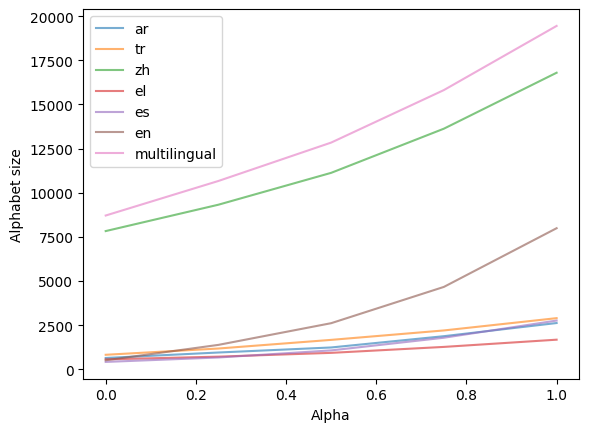

In [6]:
plt.figure()

for lang, alphabet_size in alphabet_sizes.items():
    plt.plot(alphas_num, alphabet_size, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Alphabet size")
plt.legend()

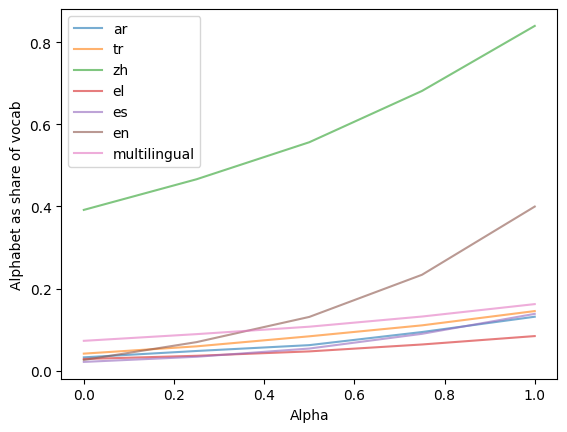

In [7]:
plt.figure()

for lang, alphabet_size in alphabet_sizes.items():
    if lang == "multilingual":
        plt.plot(alphas_num, alphabet_size/NV_multi, label=lang, alpha=0.6)
    else:
        plt.plot(alphas_num, alphabet_size/NV_mono, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Alphabet as share of vocab")
plt.legend()

In [8]:
alphabet_sizes

{'ar': array([ 647,  957, 1242, 1881, 2626]),
 'tr': array([ 828, 1183, 1672, 2206, 2902]),
 'zh': array([ 7832,  9325, 11129, 13629, 16797]),
 'el': array([ 567,  723,  937, 1274, 1683]),
 'es': array([ 424,  675, 1076, 1793, 2766]),
 'en': array([ 519, 1389, 2617, 4671, 7994]),
 'multilingual': array([ 8713, 10669, 12842, 15815, 19447])}

**For zh it's possible to have bigger alphabet than set vocabulary. Should be solved with SentencePiece**

### Measure token acceptance in m-lingual vocab

In [9]:
accepted_shares = {}
for lang in languages:
    accepted_shares[lang] = np.array([tokens_acceptance(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])


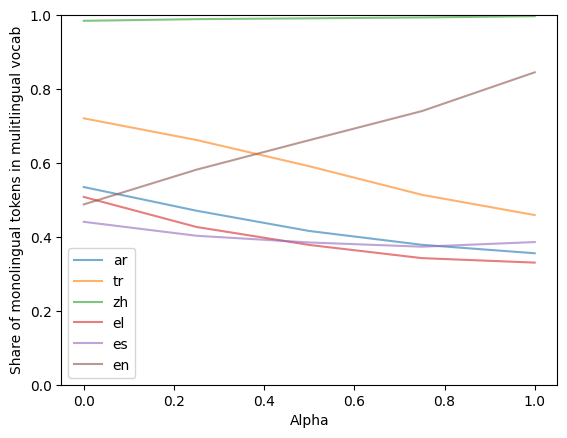

In [10]:
plt.figure()

for lang, accepted_share in accepted_shares.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab")
plt.ylim([0.0, 1.0])
plt.legend()

Without considering alphabet.

In [11]:
accepted_shares_no_alphabet = {}
for lang in languages:
    accepted_shares_no_alphabet[lang] = np.array([tokens_acceptance_no_alphabet(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

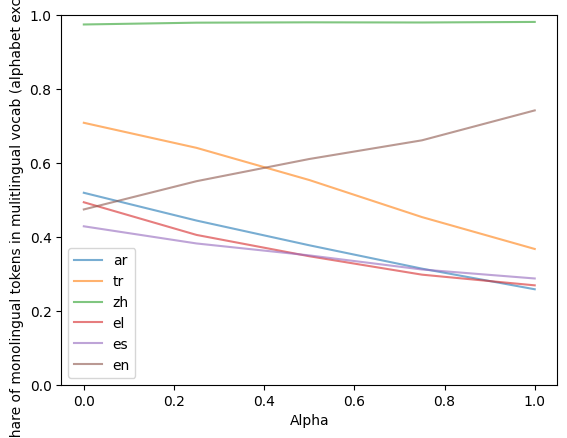

In [12]:
plt.figure()

for lang, accepted_share in accepted_shares_no_alphabet.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab (alphabet excluded)")
plt.ylim([0.0, 1.0])
plt.legend()

### Measure overlap between languages

In [13]:
all_overlap_shares_exact = np.array([tokens_overlap_exact([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                                    multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

all_overlap_shares = np.array([tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                              multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

In [14]:
np.abs(all_overlap_shares_exact - all_overlap_shares )

array([0., 0., 0., 0., 0.])

**exact means that we take into account mulilingual tokenizer in the intersection. It shouldn't have any influence because monolingual overlap should be included in it. In practice there are minor differences between two resulting sets.**

In [15]:
for alpha in alphas:
    print(f"Overlap for all languages for alpha: {alpha}")
    print_tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages], multi_tokenizer[f"alpha{alpha}"])
    

Overlap for all languages for alpha: 0.0
['!', '"', '#', '$', '%', '&', "'", '(', ')', '):', '*', '+', ',', '-', '-1', '-12', '-2', '.', '...', '................', '.com', '.com/', '/', '0', '00', '000', '01', '04', '05', '06', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2010', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '42', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '55', '56', '57', '58', '59', '6', '60', '61', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AL', 'AN', 'B', 'Book', 'C', 'D', 'E', 'ER', 'F', 'G', 'GB', 'H', 'I', 'IP', 'IS', 'J

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '**', '+', ',', '-', '-1', '.', '...', '.com', '.com/', '.html', '/', '0', '00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2017', '2018', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '500', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '74', '75', '76', '77', '78', '79', '8', '80', '800', '82', '84', '85', '86', '87', '88', '89', '9', '90', '91', '93', '94', '95', '96', '97', '98', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AN', 'AR', 'AS', 'AT', 'B', 'C', 'CO', 'D', 'E', 'ER', 'ES', 'F', 'G', 'H', 'I', 'IC', 'ID', 'IN', 'IP', 'IS', 

Text(0, 0.5, 'Overlap between all languages')

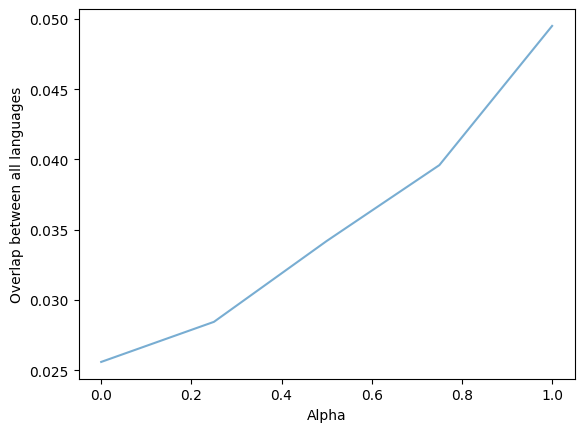

In [16]:
plt.figure()

plt.plot(alphas_num, all_overlap_shares_exact, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Overlap between all languages")



## Measuring Overlap between pairs of languages

In [17]:
overlap_maps = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

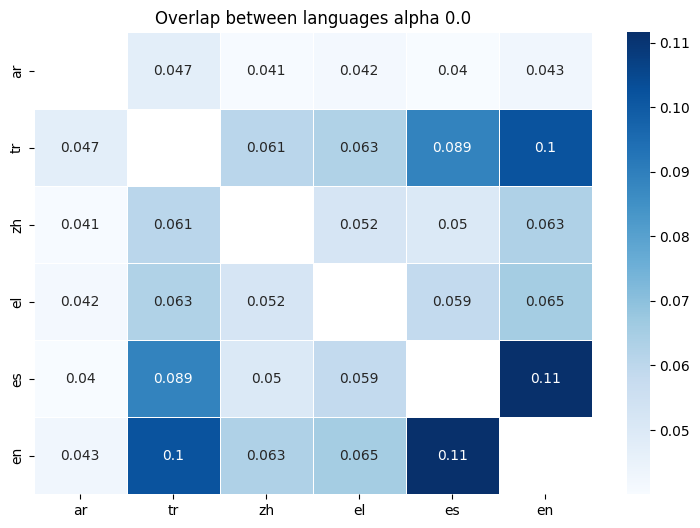

<Figure size 640x480 with 0 Axes>

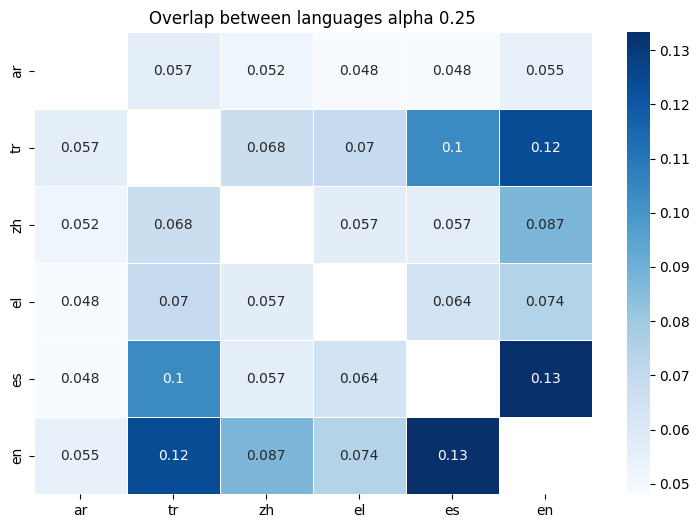

<Figure size 640x480 with 0 Axes>

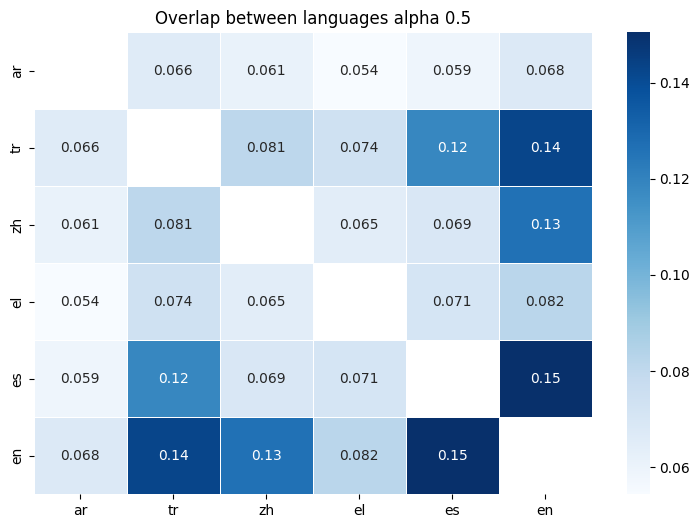

<Figure size 640x480 with 0 Axes>

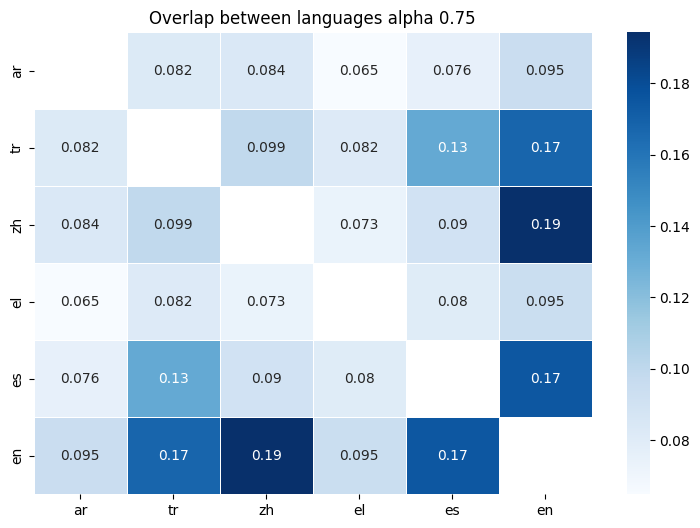

<Figure size 640x480 with 0 Axes>

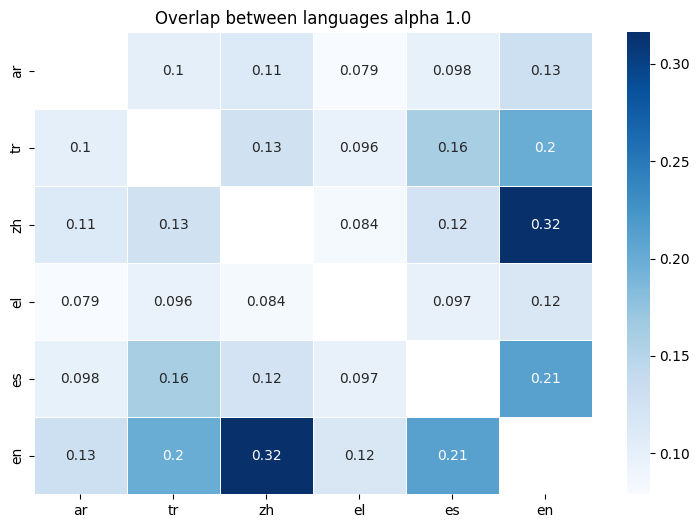

In [18]:
for alpha in alphas:
    plt.figure()


    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps[f"alpha{alpha}"], mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()

**Overlaps are so small because it's normalized for**

## Without alphabet

In [19]:
overlap_maps_no_alphabet = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact_no_alphabet([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps_no_alphabet[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

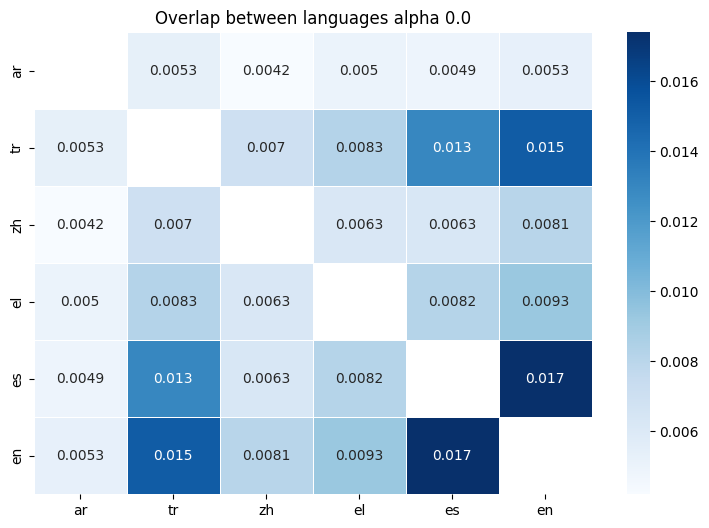

<Figure size 640x480 with 0 Axes>

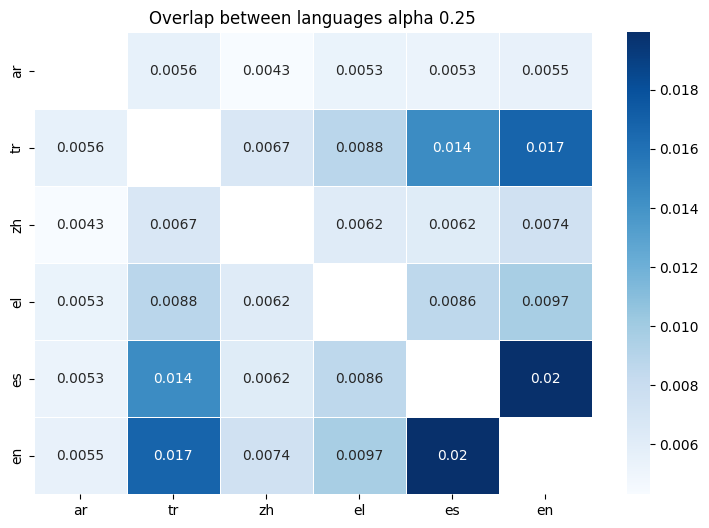

<Figure size 640x480 with 0 Axes>

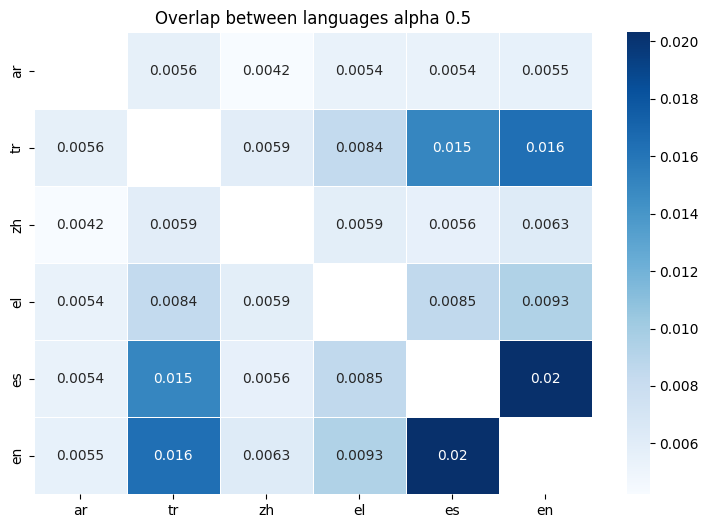

<Figure size 640x480 with 0 Axes>

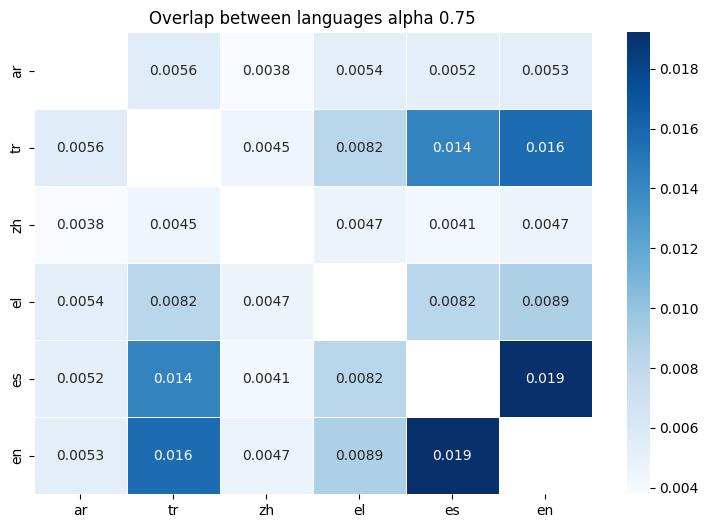

<Figure size 640x480 with 0 Axes>

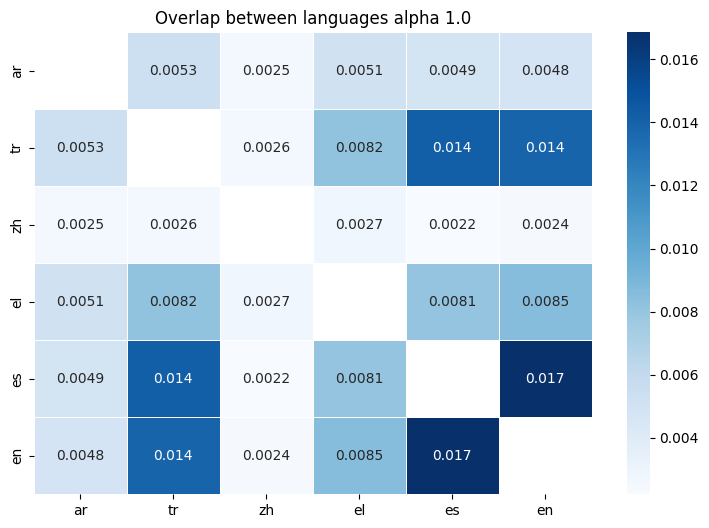

In [20]:
for alpha in alphas:
    plt.figure()


    
    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps_no_alphabet[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps_no_alphabet[f"alpha{alpha}"], annot=True, mask=mask, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()

# Properties for XLM-Roberta Tokenizer

Download and save tokenizer

In [21]:
model_name = 'xlm-roberta-base'
save_path = f"/lnet/work/people/limisiewicz/entangled-in-scripts/tokenizers/{model_name}"

In [22]:


xlmr_tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

xlmr_tokenizer.save_pretrained(save_path)
config.save_pretrained(save_path)

with open(os.path.join(save_path,'vocab.json'), "w", encoding='utf-8') as outfile:
    json.dump(dict(sorted(xlmr_tokenizer.get_vocab().items(), key=lambda item: item[1])),
              outfile, indent=2, ensure_ascii=False)

xlmr_tokenizer = AutoTokenizer.from_pretrained(save_path)

In [23]:
print_alphabet_stats(xlmr_tokenizer, "XLM-Roberta")

Results for XLM-Roberta.
Size of alphabet: 13828
Size of vocabulary: 250002
Ratio: 0.05531155750753994
